In [1]:
import os
import numpy as np
import pandas as pd
import geopandas
import fiona
import rasterio
from rasterio.mask import mask

In [45]:
fb = 175
fr = 9
# set home directory
#home_path = os.getcwd()[:os.getcwd().find('Code/python/obf_autax/ekl')-1]
home_path = '/home/philipp'
# set shape_path
shape_path = os.path.join(home_path, 'Data', 'edin_diss', 'GIS_wo', '2020', 'wo_2020_{}_{}.shp'.format(fb,fr))
# set tiff_path
tiff_path = '/media/philipp/ed7d22ba-5a3b-4d31-bf6c-6add6e106b3d/DSM/{}/FB{}_vor.tif'.format(fb,fb)
#tiff_path = os.path.join(home_path, 'Data', 'obf_autax', 'ekl', 'tiff', 'FB171_ndsm.tif')
# set output_path
output_path = os.path.join(home_path, 'Data', 'edin_diss', 'GIS_wo', 'change', 'wo_2020_{}_{}_change.shp'.format(fb,fr))

print(home_path)
print(shape_path)
print(tiff_path)
print(output_path)

/home/philipp
/home/philipp/Data/edin_diss/GIS_wo/2020/wo_2020_175_9.shp
/media/philipp/ed7d22ba-5a3b-4d31-bf6c-6add6e106b3d/DSM/175/FB175_vor.tif
/home/philipp/Data/edin_diss/GIS_wo/change/wo_2020_175_9_change.shp


In [46]:
# load geopandas
wo_geo = geopandas.read_file(shape_path)

# load shapefile with polygons
with fiona.open(shape_path) as shapefile:
    polygons = [feature for feature in shapefile]
    
# load raster with volume information
raster = rasterio.open(tiff_path)

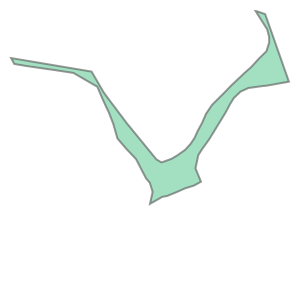

In [47]:
wo_geo.loc[159, 'geometry']

In [48]:
wo_geo['clear_area'] = 0
wo_geo['clear_area'] =  wo_geo['clear_area'].astype(np.float32)
wo_geo['wood_area'] = 0
wo_geo['wood_area'] =  wo_geo['wood_area'].astype(np.float32)
wo_geo['v_mean'] = 0
wo_geo['v_mean'] =  wo_geo['v_mean'].astype(np.float32)
wo_geo['clear_check'] = 0
wo_geo['clear_check'] =  wo_geo['clear_check'].astype(np.int8)

In [49]:
wo_geo.head()

,fb,fr,abt,uabt,teilfl,admin,length,area,fly_date,year_fly,...,zp,ru,sg,ma,year_fe,geometry,clear_area,wood_area,v_mean,clear_check
0,175,9,65535,0,1,596,1236.221802,90844.929688,08.08.2017,225,...,0,0,0,0,0,"POLYGON ((397042.320 459396.235, 396991.680 45...",0.0,0.0,0.0,0
1,175,9,65535,0,1,596,579.820801,11717.342773,08.08.2017,225,...,0,0,0,0,0,"POLYGON ((396980.991 459778.986, 396974.930 45...",0.0,0.0,0.0,0
2,175,9,65535,0,1,596,295.134796,2688.946289,08.08.2017,225,...,0,0,0,0,0,"POLYGON ((396842.200 459919.965, 396836.360 45...",0.0,0.0,0.0,0
3,175,9,1,3,1,596,3265.956299,16236.074219,08.08.2017,225,...,0,0,0,0,2016,"POLYGON ((403825.236 461200.019, 403833.950 46...",0.0,0.0,0.0,0
4,175,9,1,A,1,596,2188.830322,56229.468750,08.08.2017,225,...,0,0,0,0,2016,"POLYGON ((404123.799 460868.718, 404132.292 46...",0.0,0.0,0.0,0


In [50]:
i = 159
#polygons[i]
polygons[i]['geometry']

{'type': 'Polygon',
 'coordinates': [[(402366.1700000018, 459297.9651999995),
   (402358.9799999967, 459263.69519999996),
   (402373.3200000003, 459228.7052000016),
   (402354.9549999982, 459218.6882000007),
   (402330.59899999946, 459211.0472000018),
   (402310.5399999991, 459201.9732000008),
   (402284.751000002, 459191.46620000154),
   (402271.8570000008, 459189.07820000127),
   (402239.8269999996, 459170.81819999963),
   (402246.8200000003, 459202.0751999989),
   (402239.4200000018, 459225.8852000013),
   (402229.3400000036, 459237.86520000175),
   (402213.0689999983, 459269.30319999903),
   (402203.3999999985, 459287.98519999906),
   (402177.4299999997, 459315.37519999966),
   (402154.700000003, 459341.86520000175),
   (402143.9399999976, 459379.5751999989),
   (402132.3100000024, 459409.8552000001),
   (402116.4900000021, 459443.3552000001),
   (402102.049999997, 459477.315200001),
   (402094.43400000036, 459481.7272000015),
   (402039.5900000036, 459513.4952000007),
   (401992.4

In [51]:
def func_compute_cange_area(geom, raster):

    # cutting the raster
    out_image, out_transform = mask(raster, [geom], crop=True)
    # set no data to np.nan
    out_image[out_image<-3.3e+38]=np.nan
    # flatten array
    flat = out_image.flatten()
    # delete nan
    flat = flat[~np.isnan(flat)]
    # set values under 0 to 0
    flat[flat < 0] = 0
    
    if flat.size == 0:
        return 0,0,0
    else:
        clear_count = flat[flat < 11].size

        wood_count = flat[flat > 100].size

        return flat.mean(), clear_count/flat.size*100, wood_count/flat.size*100

In [52]:
for i in range(wo_geo.shape[0]):
    
    mean_v, clear_area, wood_area = func_compute_cange_area(polygons[i]['geometry'], raster)
    wo_geo.loc[i,'clear_area'] = clear_area
    wo_geo.loc[i,'wood_area'] = wood_area
    wo_geo.loc[i,'mean_v'] = mean_v
    
    if wo_geo.loc[i,'age'] > 15:
        if clear_area > 50:
            wo_geo.loc[i,'clear_check'] = 3
        elif clear_area > 20:
            wo_geo.loc[i,'clear_check'] = 2
        elif clear_area > 10:
            wo_geo.loc[i,'clear_check'] = 1
            
    if wo_geo.loc[i,'age'] < 15:
        if wood_area > 50:
            wo_geo.loc[i,'clear_check'] = -3
        elif wood_area > 20:
            wo_geo.loc[i,'clear_check'] = -2
        elif wood_area > 10:
            wo_geo.loc[i,'clear_check'] = -1
            
print('finished')

finished


In [53]:
# save to file
save_path = os.path.join(home_path, 'Data', 'edin_diss', 'GIS_wo', 'change', 'wo_2020_{}_{}_change.shp'.format(fb,fr))
wo_geo.to_file(save_path)

In [54]:
wo_geo['clear_check'].unique()

array([ 0, -3, -2,  2, -1,  1,  3], dtype=int8)

In [35]:
geom = polygons[25]['geometry']
# cutting the raster
out_image, out_transform = mask(raster, [geom], crop=True)

In [36]:
out_image
out_image[out_image<-3.3e+38]=np.nan
# flatten array
flat = out_image.flatten()
# delete nan
flat = flat[~np.isnan(flat)]
# set values under 0 to 0
flat[flat < 0] = 0

In [37]:
flat

array([310.5578 , 308.58514, 351.33405, 331.8401 , 338.8555 , 340.51566,
       335.17276, 331.05054, 293.36472, 276.45587, 273.7213 , 272.48083,
       204.99553, 299.58673, 315.82678, 345.36258, 332.92493, 321.7848 ,
       313.29004, 389.65973, 350.0726 , 339.19403, 338.83517, 342.51572,
       336.7094 , 298.3713 , 285.87906, 299.212  , 302.55505, 274.4575 ,
       321.6902 , 354.92468, 356.76514, 354.18518, 355.4847 , 260.6752 ,
       353.91107, 341.63504, 348.8057 , 349.5199 , 330.19238, 312.16913,
       308.02512, 328.92856, 346.10965, 343.94226, 263.98633, 339.32343,
       335.37845, 344.24112, 356.72256, 234.47746, 388.22232, 360.3956 ,
       344.9598 , 341.08905, 294.46362, 272.741  , 317.53336, 356.7959 ,
       362.66238, 360.9994 , 270.5716 , 279.81638, 336.29083, 336.74518,
       347.58   , 251.27455, 352.40634, 329.02048, 338.7995 , 338.50488,
       303.10922, 264.81412, 301.63577, 357.0936 , 358.03757, 288.93295,
       250.53044, 250.88809, 235.78233, 241.1785 , 

In [38]:
unique, counts = np.unique(flat, return_counts=True)
counts = dict(zip(unique, counts))

In [39]:
counts

{76.23992: 1,
 106.38083: 1,
 179.3217: 1,
 180.44264: 1,
 190.31647: 1,
 195.84746: 1,
 198.22836: 1,
 198.35251: 1,
 198.67644: 1,
 198.93974: 1,
 204.99553: 1,
 212.92511: 1,
 215.30473: 1,
 216.32115: 1,
 224.54749: 1,
 226.20586: 1,
 226.7679: 1,
 230.36342: 1,
 234.0921: 1,
 234.47746: 1,
 235.78233: 1,
 237.27942: 1,
 239.76886: 1,
 241.1785: 1,
 243.23872: 1,
 245.88185: 1,
 250.53044: 1,
 250.77682: 1,
 250.88809: 1,
 251.27455: 1,
 252.21117: 1,
 253.5881: 1,
 260.6752: 1,
 262.44836: 1,
 263.98633: 1,
 264.81412: 1,
 270.5716: 1,
 271.481: 1,
 271.73868: 1,
 272.48083: 1,
 272.741: 1,
 273.7213: 1,
 274.4575: 1,
 274.5716: 1,
 276.45587: 1,
 278.33722: 1,
 279.81638: 1,
 281.92712: 1,
 285.87906: 1,
 288.82892: 1,
 288.93295: 1,
 289.41995: 1,
 293.36472: 1,
 294.46362: 1,
 294.9732: 1,
 298.3713: 1,
 299.212: 1,
 299.58673: 1,
 301.63577: 1,
 302.55505: 1,
 303.10922: 1,
 308.02512: 1,
 308.58514: 1,
 310.5578: 1,
 312.16913: 1,
 313.29004: 1,
 315.82678: 1,
 317.53336: 1,


In [40]:
counts.get(0)

In [41]:
counts[0]

KeyError: 0

In [98]:
flat.shape

(54208,)

In [99]:
counts[0]/flat.shape[0]*100

27.839064344746163

In [92]:
polygons[3159]

{'type': 'Feature',
 'id': '3159',
 'properties': OrderedDict([('fb', 172),
              ('fr', 2),
              ('abt', 165),
              ('uabt', 'H'),
              ('teilfl', 1),
              ('admin', 549),
              ('length', 1329.9312744140625),
              ('area', 54203.484375),
              ('fly_date', '08.08.2017'),
              ('year_fly', 225),
              ('WO', '17202165H1'),
              ('fb_sap', 172),
              ('fr_sap', 2),
              ('abt_sap', 165),
              ('uabt_sap', 'H'),
              ('teilfl_sap', 1),
              ('start_term', '01.01.2012'),
              ('uz', 140),
              ('non_forest', 0),
              ('economy', 'I'),
              ('ww_sw', 'W'),
              ('sw_type', '0'),
              ('sea_level', 500),
              ('exp', 'W'),
              ('slope', 47),
              ('site_type', 71),
              ('veg_type', 'AHD'),
              ('growth_are', '9.2'),
              ('age', 120),
        

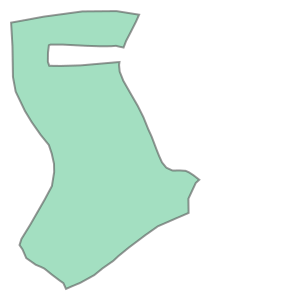

In [14]:
x

In [11]:
1024*2/60

34.13333333333333